# Import Libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch

# Dataset

In [308]:
df = pd.read_csv("data/NYCTaxiFares.csv")

In [309]:
data = df.drop("fare_amount", axis=1)
label = df.fare_amount

In [310]:
def haversine_distance(df, lat1, long1, lat2, long2):

    r = 6371  # average radius of Earth in kilometers

    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])

    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * \
        np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)  # in kilometers

    return d

In [311]:
data['dist_km'] = haversine_distance(
        data, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [312]:
data['EDTdate'] = pd.to_datetime(
        data['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)

data['Hour'] = data['EDTdate'].dt.hour
data['AMorPM'] = np.where(data['Hour'] < 12, 'am', 'pm')
data['Weekday'] = data['EDTdate'].dt.strftime("%a")

In [313]:
data.drop(["pickup_datetime", "EDTdate"], axis=1, inplace=True)

In [314]:
categorical_columns = ["Hour", "AMorPM", "Weekday"]
numeric_columns = [column for column in data.columns if column not in set(categorical_columns)]

In [315]:
categorical_columns

['Hour', 'AMorPM', 'Weekday']

In [316]:
numeric_columns

['fare_class',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'dist_km']

In [317]:
for categorical_column in categorical_columns:
    data[categorical_column] = data[categorical_column].astype("category")

In [318]:
data['Hour'] = data['Hour'].cat.codes.values
data['AMorPM'] = data['AMorPM'].cat.codes.values
data['Weekday'] = data['Weekday'].cat.codes.values

In [319]:
data.head()

,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,Hour,AMorPM,Weekday
0,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,4,0,1
1,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,11,0,2
2,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,7,0,2
3,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,17,1,3
4,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,22,1,0


In [342]:
X_train, X_test, y_train, y_test = train_test_split(data[:200].values, label[:200].values, test_size=0.33, random_state=42)

In [343]:
class NYCTaxiFare(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        current_data = self.data[idx, :]
        current_label = self.label[idx]
        
        return (
            torch.tensor(current_data, dtype=torch.float64),
            torch.tensor(current_label, dtype=torch.float64)
        )
        

In [344]:
train_dataset = NYCTaxiFare(X_train, y_train)
test_dataset = NYCTaxiFare(X_test, y_test)

In [345]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset)//4)

# Tensor Class

In [178]:
class ScalerTensor:
    def __init__(self, data=0, children=()):
        self.data = data
        self.grad=0 # defines dloss / dself
        self._backward=lambda: None
        self._childern=set(children)
    
    def backward(self, visited_nodes=None):
        if visited_nodes is None:
            visited_nodes = set([self])
            self.grad = 1 # partial derivated w.r.t itself
        
        self._backward()
        
        for children in self._childern:
            
            if children not in visited_nodes:
                visited_nodes.add(children)
                children.backward(visited_nodes)
            
    
    def __add__(self, second_scaler_tensor):
        # make sure second_scaler_tensor is object of ScalerTensor
        second_scaler_tensor = second_scaler_tensor if isinstance(second_scaler_tensor, ScalerTensor) else ScalerTensor(second_scaler_tensor)
        
        output = ScalerTensor(second_scaler_tensor.data + self.data, children=set([self, second_scaler_tensor]))
        
        # _backward function for output        
        def _backward():
            # output = self + second_scaler_tensor

            # dloss / dself = (dloss / doutput) * (doutput / dself)
            # dloss / dself = (dloss / doutput) * (d(self + second_scaler_tensor) / dself)
            # dloss / dself = output.grad * [ (dself/ dself) + (dsecond_scaler_tensor/ dself)]
            # dloss / dself = output.grad *[1 + 0]

            # Similarly
            # dloss / dsecond_scaler_tensor = output.grad
            
            self.grad += output.grad
            second_scaler_tensor.grad += output.grad
        
        setattr(output, '_backward', _backward)
        
        return output
    
    def __radd__(self, other): return self + other    
    
    def __mul__(self, second_scaler_tensor):
        # make sure second_scaler_tensor is object of ScalerTensor
        second_scaler_tensor = second_scaler_tensor if isinstance(second_scaler_tensor, ScalerTensor) else ScalerTensor(second_scaler_tensor)
        
        output = ScalerTensor(second_scaler_tensor.data * self.data, children=set([self, second_scaler_tensor]))
        
        # _backward function for output
        def _backward():
            # output = self * second_scaler_tensor

            # dloss / dself = (dloss / doutput) * (doutput / dself)
            # dloss / dself = (dloss / doutput) * (d(self * second_scaler_tensor) / dself)
            # dloss / dself = output.grad * [ (dself/ dself) * second_scaler_tensor + (dsecond_scaler_tensor/ dself) * self]
            # dloss / dself = output.grad *[second_scaler_tensor + 0]

            # Similarly
            # dloss / dsecond_scaler_tensor = output.grad * self
            self.grad += output.grad * second_scaler_tensor.data
            second_scaler_tensor.grad += output.grad * self.data
        
        setattr(output, '_backward', _backward)
        
        return output
    
    def __rmul__(self, other): return self * other
    
    def __pow__(self, power):
        
        output = ScalerTensor(self.data ** power, children=set([self]))
        
        # _backward function for output
        def _backward():
            # output = self ** power

            # dloss / dself = (dloss / doutput) * (doutput / dself)
            # dloss / dself = (dloss / doutput) * (d(self ** power) / dself)
            # dloss / dself = output.grad * [ power * self ** (power - 1)]
            self.grad += output.grad * power * (self.data ** (power - 1))

        
        setattr(output, '_backward', _backward)
        
        return output
    
    def relu(self):
        output = ScalerTensor(self.data if self.data > 0 else 0, children=set([self]))
        
         # _backward function for output
        def _backward():
            self.grad += (output.data > 0) * output.grad
        
        setattr(output, '_backward', _backward)
        
        return output
    
    def __sub__(self, other): return self + (-1 * other)

    def __rsub__(self, other): return (-1 * self) + other
    
    def __str__(self): return str(self.data)
    
    def __repr__(self): return str(self.data)

## Testing the Scaler Tensor Class

In [179]:
# input featues
x1 = ScalerTensor(5)
x2 = ScalerTensor(10)

# weights
w1 = ScalerTensor(1)
w2 = ScalerTensor(7)

# bias
b = ScalerTensor(-20)

# true value
y = ScalerTensor(25)

In [180]:
# predicted value
y_hat = (x1 * w1) + (x2 * w2) + b

In [181]:
# loss
loss = (y_hat - y)**2

In [182]:
loss.data

900

### Note: dx = dloss/dx

dloss = 1

dy_hat = 2 * (y_hat - y) = 60

dy = 2 * (y - yhat) = -60

dw1 = dy_hat * dy_hat / dw1
    = dy_hat * x1 = 300
    
dw2 = dy_hat * x2 = 600

In [183]:
loss.backward()

In [184]:
print(loss.grad, y_hat.grad, y.grad, w1.grad, w2.grad)

1 60 -60 300 600


# Layer

In [207]:
class Layer:
    def __init__(self, input_size, output_size, add_relu=True):
        self.input_size = input_size
        self.output_size = output_size
        self.add_relu = add_relu
        
        self.weights = [[ScalerTensor(random.gauss(0, 1/max(input_size, output_size))) for _ in range(self.output_size)] for _ in range(self.input_size)]
        self.bias = [ScalerTensor(random.gauss(0, 1/max(input_size, output_size))) for _ in range(self.output_size)]
    
    def __call__(self, X):
        
        y = list()        
        for out in range(self.output_size):
            neuron_output = 0
            for inp in range(self.input_size):
                neuron_output += self.weights[inp][out] * X[inp]
            
            neuron_output = neuron_output + self.bias[out]
            if self.add_relu:
                neuron_output = neuron_output.relu()
            
            y.append(neuron_output)
        
        return y

## Testing Layer

In [215]:
# input featues
x1 = ScalerTensor(5)
x2 = ScalerTensor(10)

In [216]:
layer = Layer(2, 1)

In [217]:
y = layer([x1, x2])

In [218]:
layer.weights

[[0.05348264518643036], [0.7669990523026644]]

In [219]:
layer.bias

[0.10523488178362288]

In [229]:
(x1.data * layer.weights[0][0] + x2.data * layer.weights[1][0] + layer.bias[0]) 

8.042638630742418

In [230]:
y[0]

8.042638630742418

# Network

In [232]:
class NeuralNetowrk:
    def __init__(self, *layers, learning_rate=0.01):
        self.layers = layers
        self.learning_rate = learning_rate
        
        parameters = list()
        
        for layer in self.layers:
            for weights in layer.weights:
                parameters.extend(weights)
            
            parameters.extend(layer.bias)
        
        self.parameters = parameters
  
    def update(self):
        
        for parameter in self.parameters:
            parameter.data -= parameter.grad * self.learning_rate
    
    def zero_grad(self):
        
        for parameter in self.parameters:
            parameter.grad = 0
    
    def loss(self, y_hat, y):
        return ((y_hat - y) ** 2)

    def __call__(self, X):
        
        for layer in self.layers:
            X = layer(X)
        
        return X

# Training and Evaluation

In [350]:
model = NeuralNetowrk(Layer(10, 32), Layer(32, 16), Layer(16, 8), Layer(8, 1, add_relu=False))

In [351]:
EPOCHS = 50

history = {"train_loss": list(), "validation_loss": list()}

for epoch in range(1, EPOCHS + 1):
    print(f"<---- Epoch - {epoch} ---->")
    
    batch_train_loss = 0
    
    for train_idx, (X_train, y_train) in enumerate(train_loader):
                
        X_train = X_train.tolist()
        y_train = y_train.tolist()
        loss = 0
        for idx, X in enumerate(X_train):
        
            y_hat = model(X)
            
            loss += model.loss(y_hat[0], y_train[idx])            
            
        loss *= 1 / len(X_train)
        
        loss.backward()
        model.update()
        model.zero_grad()
        
        batch_train_loss += loss.data
    
    batch_test_loss = 0
    
    for test_idx, (X_test, y_test) in enumerate(test_loader):
        X_test = X_test.tolist()
        y_test = y_test.tolist()
        
        loss = 0
        for idx, X in enumerate(X_test):
            y_hat = model(X)
            loss += model.loss(y_hat[0], y_test[idx])
        
        loss *= 1 / len(X_test)
        
        
        batch_test_loss += loss.data
                    
    history["train_loss"].append(batch_train_loss)
    history["validation_loss"].append(batch_test_loss)
    
    print(f"train_loss: {batch_train_loss}")
    print(f"validation_loss: {batch_test_loss}")

<---- Epoch - 1 ---->
train_loss: 562.3190576238504
validation_loss: 860.5119328506929
<---- Epoch - 2 ---->
train_loss: 461.85444727390984
validation_loss: 579.5967778720793
<---- Epoch - 3 ---->
train_loss: 234.2682207351505
validation_loss: 406.20107633705146
<---- Epoch - 4 ---->
train_loss: 10815.879257319837
validation_loss: 823.3458485473794
<---- Epoch - 5 ---->
train_loss: 528.9680844809484
validation_loss: 752.2315175470678
<---- Epoch - 6 ---->
train_loss: 397.8345545903924
validation_loss: 698.4262238433927
<---- Epoch - 7 ---->
train_loss: 373.61320910037165
validation_loss: 652.1697562245542
<---- Epoch - 8 ---->
train_loss: 349.8373642875499
validation_loss: 612.2702496377984
<---- Epoch - 9 ---->
train_loss: 347.80869775398907
validation_loss: 577.5191751397001
<---- Epoch - 10 ---->
train_loss: 300.422598691681
validation_loss: 549.5031073131597
<---- Epoch - 11 ---->
train_loss: 270.8189431000713
validation_loss: 526.7607382802549
<---- Epoch - 12 ---->
train_loss: 25

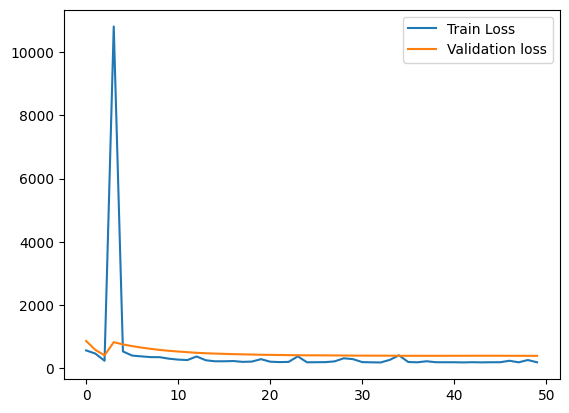

In [352]:
sns.lineplot(x=range(0, len(history["train_loss"])), y=history["train_loss"], label="Train Loss")
sns.lineplot(x=range(0, len(history["validation_loss"])), y=history["validation_loss"], label="Validation loss")
plt.legend()
plt.show()